In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import sys
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

%matplotlib inline

from sklearn.model_selection import train_test_split

from tqdm import tqdm_notebook #, tnrange
#from itertools import chain
from skimage.io import imread, imshow #, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

import keras
from keras.models import Model, load_model, save_model
from keras.layers import Input,Dropout,BatchNormalization,Activation,Add
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K
from keras import optimizers

import tensorflow as tf

from keras.preprocessing.image import array_to_img, img_to_array, load_img#,save_img

import time
from kaggle_util import *
from models import *

t_start = time.time()

Using TensorFlow backend.


In [2]:
img_size_ori = 101
img_size_target = 101

def upsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_target, img_size_target), mode='constant', preserve_range=True)
    
def downsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_ori, img_size_ori), mode='constant', preserve_range=True)

def build_model_deeper(input_layer, start_neurons, DropoutRatio = 0.5):
    # 101 -> 50
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(input_layer)
    conv1 = residual_block(conv1,start_neurons * 1)
    conv1 = residual_block(conv1,start_neurons * 1)
    conv1 = residual_block(conv1,start_neurons * 1, True)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(DropoutRatio/2)(pool1)

    # 50 -> 25
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(pool1)
    conv2 = residual_block(conv2,start_neurons * 2)
    conv2 = residual_block(conv2,start_neurons * 2)
    conv2 = residual_block(conv2,start_neurons * 2, True)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(DropoutRatio)(pool2)

    # 25 -> 12
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(pool2)
    conv3 = residual_block(conv3,start_neurons * 4)
    conv3 = residual_block(conv3,start_neurons * 4)
    conv3 = residual_block(conv3,start_neurons * 4, True)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(DropoutRatio)(pool3)

    # 12 -> 6
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(pool3)
    conv4 = residual_block(conv4,start_neurons * 8)
    conv4 = residual_block(conv4,start_neurons * 8)
    conv4 = residual_block(conv4,start_neurons * 8, True)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(DropoutRatio)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(pool4)
    convm = residual_block(convm,start_neurons * 16)
    convm = residual_block(convm,start_neurons * 16)
    convm = residual_block(convm,start_neurons * 16, True)
    
    # 6 -> 12
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(DropoutRatio)(uconv4)
    
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv4)
    uconv4 = residual_block_cSE(uconv4,start_neurons * 8)
    uconv4 = residual_block_cSE(uconv4,start_neurons * 8)
    uconv4 = residual_block_cSE(uconv4,start_neurons * 8, True)
    
    # 12 -> 25
    #deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="valid")(uconv4)
    uconv3 = concatenate([deconv3, conv3])    
    uconv3 = Dropout(DropoutRatio)(uconv3)
    
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = residual_block_cSE(uconv3,start_neurons * 4)
    uconv3 = residual_block_cSE(uconv3,start_neurons * 4)
    uconv3 = residual_block_cSE(uconv3,start_neurons * 4, True)

    # 25 -> 50
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
        
    uconv2 = Dropout(DropoutRatio)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = residual_block_cSE(uconv2,start_neurons * 2)
    uconv2 = residual_block_cSE(uconv2,start_neurons * 2)
    uconv2 = residual_block_cSE(uconv2,start_neurons * 2, True)
    
    # 50 -> 101
    #deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="valid")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    
    uconv1 = Dropout(DropoutRatio)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = residual_block_cSE(uconv1,start_neurons * 1)
    uconv1 = residual_block_cSE(uconv1,start_neurons * 1)
    uconv1 = residual_block_cSE(uconv1,start_neurons * 1, True)
    
    #uconv1 = Dropout(DropoutRatio/2)(uconv1)
    #output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    output_layer_noActi = Conv2D(1, (1,1), padding="same", activation=None)(uconv1)
    output_layer =  Activation('sigmoid')(output_layer_noActi)
    
    return output_layer

In [3]:


# Loading of training/testing ids and depths
train_df = pd.read_csv("../input/train.csv", index_col="id", usecols=[0])
depths_df = pd.read_csv("../input/depths.csv", index_col="id")
train_df = train_df.join(depths_df)
test_df = depths_df[~depths_df.index.isin(train_df.index)]

len(train_df)

train_df["images"] = [np.array(load_img("../input/train/images/{}.png".format(idx), grayscale=True)) / 255 for idx in tqdm_notebook(train_df.index)]
train_df["masks"] = [np.array(load_img("../input/train/masks/{}.png".format(idx), grayscale=True)) / 255 for idx in tqdm_notebook(train_df.index)]
train_df["coverage"] = train_df.masks.map(np.sum) / pow(img_size_ori, 2)
train_df["coverage_class"] = train_df.coverage.map(cov_to_class)

/home/kownse/.local/lib/python3.6/site-packages/keras_preprocessing/image.py:487: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [4]:
SUBSET = len(train_df)
train_df = train_df.head(SUBSET)
len(train_df)

4000

In [5]:
ids_train, ids_valid, x_train, x_valid, y_train, y_valid, cov_train, cov_test, depth_train, depth_test = train_test_split(
train_df.index.values,
np.array(train_df.images.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1), 
np.array(train_df.masks.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1), 
train_df.coverage.values,
train_df.z.values,
test_size=0.2, stratify=train_df.coverage_class, random_state= 1234)

In [6]:
#Data augmentation
x_train = np.append(x_train, [np.fliplr(x) for x in x_train], axis=0)
y_train = np.append(y_train, [np.fliplr(x) for x in y_train], axis=0)
print(x_train.shape)
print(y_valid.shape)

(6400, 101, 101, 1)
(800, 101, 101, 1)


In [7]:
batch_size = 32
start_feature = 32
dropout = 0.5
basic_name = '../model/resunet_deeper_cse_up_{}_{}'.format(batch_size, dropout)
save_model_name = basic_name + '.model'
submission_file = basic_name + '.csv'

print(save_model_name)
print(submission_file)

# model
input_layer = Input((img_size_target, img_size_target, 1))
output_layer = build_model_deeper(input_layer, start_feature,dropout)

model1 = Model(input_layer, output_layer)

c = optimizers.adam(lr = 0.01)
model1.compile(loss="binary_crossentropy", optimizer=c, metrics=[my_iou_metric])

board = keras.callbacks.TensorBoard(log_dir='log/resunet_deeper_cse_up_{}_{}'.format(batch_size, dropout),
                       histogram_freq=0, write_graph=True, write_images=False)
early_stopping = EarlyStopping(monitor='val_my_iou_metric', mode = 'max',patience=10, verbose=1)
model_checkpoint = ModelCheckpoint(save_model_name,monitor='val_my_iou_metric', 
                                   mode = 'max', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_my_iou_metric', mode = 'max',factor=0.5, patience=3, min_lr=0.00001, verbose=1)

epochs = 200

history = model1.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[board, early_stopping, model_checkpoint,reduce_lr], 
                    verbose=1)

../model/resunet_deeper_cse_up_32_0.5.model
../model/resunet_deeper_cse_up_32_0.5.csv
Train on 6400 samples, validate on 800 samples
Epoch 1/200
6400/6400 [==============================] - 74s 12ms/step - loss: 0.4826 - my_iou_metric: 0.3336 - val_loss: 0.5884 - val_my_iou_metric: 0.3696

Epoch 00001: val_my_iou_metric improved from -inf to 0.36963, saving model to ../model/resunet_deeper_cse_up_32_0.5.model
Epoch 2/200
6400/6400 [==============================] - 61s 9ms/step - loss: 0.4657 - my_iou_metric: 0.3483 - val_loss: 0.6554 - val_my_iou_metric: 0.0327

Epoch 00002: val_my_iou_metric did not improve from 0.36963
Epoch 3/200
6400/6400 [==============================] - 61s 10ms/step - loss: 0.3737 - my_iou_metric: 0.4766 - val_loss: 0.5363 - val_my_iou_metric: 0.3864

Epoch 00003: val_my_iou_metric improved from 0.36963 to 0.38638, saving model to ../model/resunet_deeper_cse_up_32_0.5.model
Epoch 4/200
6400/6400 [==============================] - 62s 10ms/step - loss: 0.3735 -

Epoch 33/200
6400/6400 [==============================] - 61s 10ms/step - loss: 0.1042 - my_iou_metric: 0.7548 - val_loss: 0.1650 - val_my_iou_metric: 0.7135

Epoch 00033: val_my_iou_metric did not improve from 0.75400
Epoch 34/200
6400/6400 [==============================] - 61s 10ms/step - loss: 0.1007 - my_iou_metric: 0.7578 - val_loss: 0.1487 - val_my_iou_metric: 0.7498

Epoch 00034: val_my_iou_metric did not improve from 0.75400
Epoch 35/200
6400/6400 [==============================] - 61s 10ms/step - loss: 0.0965 - my_iou_metric: 0.7631 - val_loss: 0.1301 - val_my_iou_metric: 0.7521

Epoch 00035: val_my_iou_metric did not improve from 0.75400

Epoch 00035: ReduceLROnPlateau reducing learning rate to 0.0024999999441206455.
Epoch 36/200
6400/6400 [==============================] - 61s 10ms/step - loss: 0.0881 - my_iou_metric: 0.7716 - val_loss: 0.1370 - val_my_iou_metric: 0.7648

Epoch 00036: val_my_iou_metric improved from 0.75400 to 0.76475, saving model to ../model/resunet_deepe

In [8]:
model1 = load_model(save_model_name,custom_objects={'my_iou_metric': my_iou_metric})
# remove layter activation layer and use losvasz loss
input_x = model1.layers[0].input
output_layer = model1.layers[-1].input
model = Model(input_x, output_layer)
c = optimizers.adam(lr = 0.01)

# lovasz_loss need input range (-∞，+∞), so cancel the last "sigmoid" activation  
# Then the default threshod for pixel prediction is 0 instead of 0.5, as in my_iou_metric_2.
model.compile(loss=lovasz_loss, optimizer=c, metrics=[my_iou_metric_2])

#model.summary()
early_stopping = EarlyStopping(monitor='val_my_iou_metric_2', mode = 'max',patience=20, verbose=1)
model_checkpoint = ModelCheckpoint(save_model_name,monitor='val_my_iou_metric_2', 
                                   mode = 'max', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_my_iou_metric_2', mode = 'max',factor=0.5, patience=4, min_lr=0.00001, verbose=1)
epochs = 200
batch_size = 32

history = model.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[board, model_checkpoint,reduce_lr,early_stopping], 
                    verbose=1)

Train on 6400 samples, validate on 800 samples
Epoch 1/200
6400/6400 [==============================] - 110s 17ms/step - loss: -0.0383 - my_iou_metric_2: 0.7743 - val_loss: 0.1565 - val_my_iou_metric_2: 0.7452

Epoch 00001: val_my_iou_metric_2 improved from -inf to 0.74525, saving model to ../model/resunet_deeper_cse_up_32_0.5.model
Epoch 2/200
6400/6400 [==============================] - 97s 15ms/step - loss: -0.0920 - my_iou_metric_2: 0.7815 - val_loss: 0.1051 - val_my_iou_metric_2: 0.7460

Epoch 00002: val_my_iou_metric_2 improved from 0.74525 to 0.74600, saving model to ../model/resunet_deeper_cse_up_32_0.5.model
Epoch 3/200
6400/6400 [==============================] - 97s 15ms/step - loss: -0.0927 - my_iou_metric_2: 0.7794 - val_loss: 0.0860 - val_my_iou_metric_2: 0.7602

Epoch 00003: val_my_iou_metric_2 improved from 0.74600 to 0.76025, saving model to ../model/resunet_deeper_cse_up_32_0.5.model
Epoch 4/200
6400/6400 [==============================] - 97s 15ms/step - loss: -0.100

6400/6400 [==============================] - 97s 15ms/step - loss: -0.5005 - my_iou_metric_2: 0.8632 - val_loss: -0.0874 - val_my_iou_metric_2: 0.8090

Epoch 00033: val_my_iou_metric_2 did not improve from 0.81050
Epoch 34/200
6400/6400 [==============================] - 97s 15ms/step - loss: -0.5079 - my_iou_metric_2: 0.8629 - val_loss: -0.0868 - val_my_iou_metric_2: 0.8053

Epoch 00034: val_my_iou_metric_2 did not improve from 0.81050
Epoch 35/200
6400/6400 [==============================] - 97s 15ms/step - loss: -0.5171 - my_iou_metric_2: 0.8652 - val_loss: -0.0730 - val_my_iou_metric_2: 0.8096

Epoch 00035: val_my_iou_metric_2 did not improve from 0.81050
Epoch 36/200
6400/6400 [==============================] - 97s 15ms/step - loss: -0.5105 - my_iou_metric_2: 0.8653 - val_loss: -0.0580 - val_my_iou_metric_2: 0.8065

Epoch 00036: val_my_iou_metric_2 did not improve from 0.81050

Epoch 00036: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.
Epoch 37/200
6400/6400 [

In [9]:
model = load_model(save_model_name,custom_objects={'my_iou_metric_2': my_iou_metric_2,
                                                   'lovasz_loss': lovasz_loss})




[0.806    0.806375 0.807125 0.8075   0.80875  0.8075   0.806375 0.806125
 0.807125 0.807125 0.807875 0.807875 0.809    0.809    0.809    0.80875
 0.808375 0.808375 0.80825  0.80825  0.80775  0.808125 0.8065   0.807
 0.80575  0.8065   0.8055   0.80575  0.805125 0.804625 0.804625]


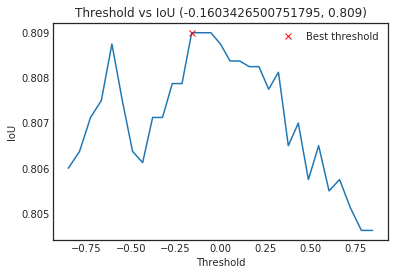

In [10]:
preds_valid = predict_result(model,x_valid,img_size_target)
## Scoring for last model, choose threshold by validation data 
thresholds_ori = np.linspace(0.3, 0.7, 31)
# Reverse sigmoid function: Use code below because the  sigmoid activation was removed
thresholds = np.log(thresholds_ori/(1-thresholds_ori)) 

# ious = np.array([get_iou_vector(y_valid, preds_valid > threshold) for threshold in tqdm_notebook(thresholds)])
# print(ious)
ious = np.array([iou_metric_batch(y_valid, preds_valid > threshold) for threshold in tqdm_notebook(thresholds)])
print(ious)

# instead of using default 0 as threshold, use validation data to find the best threshold.
threshold_best_index = np.argmax(ious) 
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

In [11]:
x_test = np.array([(np.array(load_img("../input/test/images/{}.png".format(idx), grayscale = True))) / 255 for idx in tqdm_notebook(test_df.index)]).reshape(-1, img_size_target, img_size_target, 1)

preds_test = predict_result(model,x_test,img_size_target)

/home/kownse/.local/lib/python3.6/site-packages/keras_preprocessing/image.py:487: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [12]:
t1 = time.time()
pred_dict = {idx: rle_encode(np.round(downsample(preds_test[i]) > threshold_best)) for i, idx in enumerate(tqdm_notebook(test_df.index.values))}
t2 = time.time()

print(f"Usedtime = {t2-t1} s")

sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub = sub.reset_index()
save_result(sub, '../result/res_unet_101.csv', 
                        competition = 'tgs-salt-identification-challenge', 
                        send = False, index = False)

t_finish = time.time()
print(f"Kernel run time = {(t_finish-t_start)/3600} hours")


Usedtime = 5.364121437072754 s
save result
Kernel run time = 2.692662095957332 hours
